In [1]:
from stepmix.stepmix import StepMix
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pkl

In [2]:
df = pd.read_csv("../data/cleaned_data_SYMPTOMS_9_13_23.csv", index_col=0)
sympdf = df.loc[:, df.columns.str.startswith('Symptom_')]
sympdf.shape
# filter to match
sympdf = sympdf.loc[:, (sympdf.sum() / sympdf.shape[0] > 0.05) & (sympdf.sum()  / sympdf.shape[0]< 0.95)]

In [3]:
def load_run(n_components, date):
    clusters = pd.read_csv("output/cluster_"+str(n_components)+"_"+date+".csv", index_col=0)
    mm = pd.read_csv("output/stepmix_"+str(n_components)+"_"+date+"_mmdf.csv", index_col=0)
    symp_unusual = pd.read_csv("output/stepmix_"+str(n_components)+"_"+date+"_symp_unusual.csv", index_col=0)

    file_path = "output/stepmix_"+str(n_components)+"_"+date+".pkl"

    with open(file_path, 'rb') as file:
        model = pkl.load(file)
    return({"clusters": clusters, "mm": mm, "symp_unusual": symp_unusual, "model": model})

In [7]:
# try loading the actual model and figure out how to extract the probabilities for each patient and class
n_components = 13
date = "111023"

res13 = load_run(n_components, date)

In [16]:
def filter_poor_fits(model, sympdf, clusterdf,  threshold = 0.5):
    # filter out poor fits
    # get the probability of each patient belonging to each cluster
    preddf = pd.DataFrame(model.predict_proba(sympdf),index=sympdf.index)
    print(preddf[preddf > 0.5].notna().sum(axis=1).value_counts())
    poor_fits = preddf[preddf[preddf > 0.5].notna().sum(axis=1) == 0].index.values
    clusterdf.loc[clusterdf.index.isin(poor_fits),'cluster']= np.nan
    return(clusterdf)

In [139]:
df["cluster"] = filter_poor_fits(res13["model"], sympdf, res13["clusters"])

1    5923
0     108
Name: count, dtype: int64


<Axes: xlabel='cluster'>

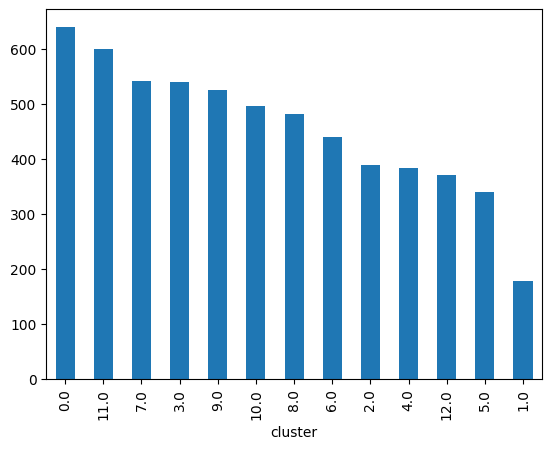

In [19]:
df["cluster"].value_counts().plot(kind="bar")
# 1 is now really small
# in a way that maybe suggests too many clusters...

In [20]:
df['cluster'].to_csv("output/cluster_13_ambiguousNaN_111023.csv")


In [24]:
for n_components in [9,11,12,13]:
    print(n_components)
    res= load_run(n_components, date)
    clust= filter_poor_fits(res["model"], sympdf, res["clusters"])
    clust.to_csv("output/cluster_"+str(n_components)+"_ambiguousNaN_111023.csv")


9
1    5977
0      54
Name: count, dtype: int64
11
1    5944
0      87
Name: count, dtype: int64
12
1    5937
0      94
Name: count, dtype: int64
13
1    5923
0     108
Name: count, dtype: int64


In [ ]:
# interestingly: the number of ambiguous assignments increases when I have more clusters
# could be an indicator that some are too similar to each other

In [25]:
# try loading the actual model and figure out how to extract the probabilities for each patient and class
n_components = 13
date = "111023"

res13 = load_run(n_components, date)

In [27]:
preddf = pd.DataFrame(res13['model'].predict_proba(sympdf),index=sympdf.index)

In [29]:
poor_fits = preddf[preddf[preddf > 0.5].notna().sum(axis=1) == 0].index.values

<Axes: >

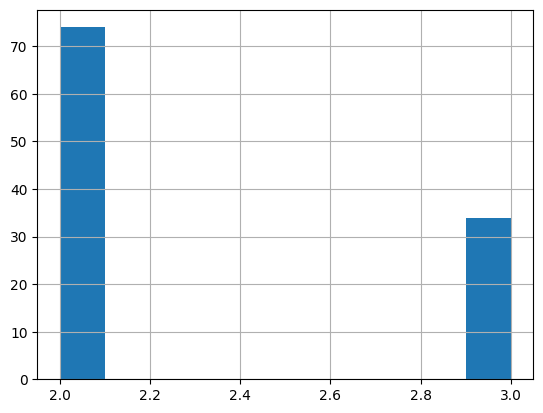

In [38]:
(preddf.loc[poor_fits]>0.2).sum(axis=1).hist()
# mostly split between two clusters -- which two?

In [44]:
(preddf.loc[poor_fits]>0.2).sum(axis=0).sort_values(ascending=False)
# pretty dispersed

booltab = preddf.loc[poor_fits]>0.2

In [45]:
# okay so for this boolean table booltab I want to know which pairs of columns are true together
# and how often that happens
# I think I can do this with a matrix multiplication
# but I need to convert the boolean table to 0 and 1

booltab = booltab.astype(int)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,32,0,0,8,0,8,0,0,7,5,7,3,6
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,19,0,0,7,8,1,0,0,2,11,0
3,8,0,0,24,5,4,0,0,6,8,4,0,0
4,0,0,0,5,11,0,0,0,3,6,0,0,0
5,8,0,7,4,0,30,3,0,0,9,4,11,1
6,0,0,8,0,0,3,26,3,0,0,5,14,2
7,0,0,1,0,0,0,3,4,0,0,1,0,0
8,7,0,0,6,3,0,0,0,15,1,1,1,0
9,5,0,0,8,6,9,0,0,1,21,0,1,0


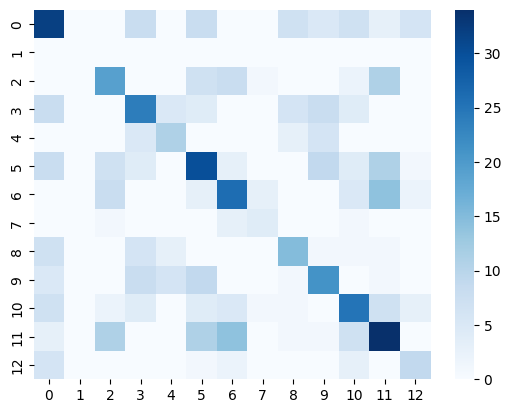

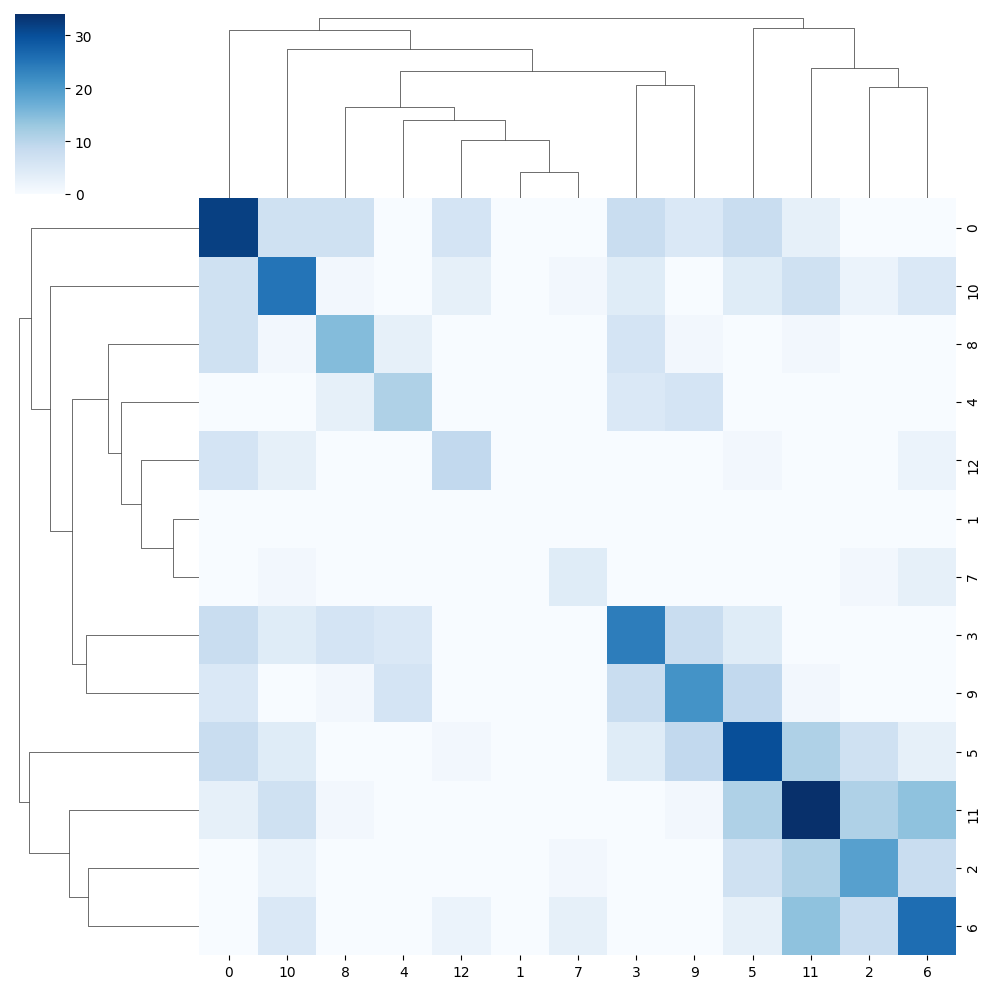

In [52]:
# I'm not really seeing 
plot = sns.heatmap(booltab.T.dot(booltab), cmap="Blues")
# same heatmap but hierarchicially clustered
plot= sns.clustermap(booltab.T.dot(booltab), cmap="Blues")

booltab.T.dot(booltab)

In [56]:
# MC permutation test cluster pairs for distinguishability
# I think I want to do this for each pair of clusters
clusters = res13["clusters"]



In [59]:
clusters['cluster'].unique()

array([ 8, 11, 10,  0,  5,  9,  7,  2,  6,  3, 12,  4,  1])

In [60]:
    groups = clusters['cluster'].unique()

    # list all pairs from n choose 2 of groups
    pairs = []
    for i in range(len(groups)):
        for j in range(i+1,len(groups)):
            pairs.append([groups[i],groups[j]])
    

In [61]:
groups

array([ 8, 11, 10,  0,  5,  9,  7,  2,  6,  3, 12,  4,  1])

In [65]:
pair = pairs[0]

In [66]:
sympair = sympdf[clusters['cluster'].isin(pair)]

In [68]:
cluspair = clusters[clusters['cluster'].isin(pair)]

In [71]:
sympair[clusters['cluster'] == pair[0]].mean() 

/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_57197/3749138398.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sympair[clusters['cluster'] == pair[0]].mean()


Symptom_Memory_short                  0.871429
Symptom_Memory_long                   0.300000
Symptom_Memory_no_new_memories        0.040816
Symptom_Memory_forget_tasks           0.034694
Symptom_Memory_other                  0.077551
                                        ...   
Symptom_SkinAllergy_brittle_nail      0.036735
Symptom_SkinAllergy_other_itchy       0.018367
Symptom_PEM                           0.785714
Symptom_Change_sensitivity_to_meds    0.079592
Symptom_New_allergies                 0.034694
Length: 147, dtype: float64

In [72]:
sympair[clusters['cluster'] == pair[1]].mean()

# I want the euclidean distance between the means of the two clusters
dist = np.linalg.norm(sympair[clusters['cluster'] == pair[0]].mean() - sympair[clusters['cluster'] == pair[1]].mean())


/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_57197/2884306579.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sympair[clusters['cluster'] == pair[1]].mean()
/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_57197/2884306579.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dist = np.linalg.norm(sympair[clusters['cluster'] == pair[0]].mean() - sympair[clusters['cluster'] == pair[1]].mean())
/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_57197/2884306579.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dist = np.linalg.norm(sympair[clusters['cluster'] == pair[0]].mean() - sympair[clusters['cluster'] == pair[1]].mean())


In [90]:
%reload_ext autoreload
%autoreload 2

import permtest

In [114]:
pvals, dists = permtest.perm_test(sympdf, clusters, nperm=100)

In [123]:
np.linalg.norm(sympair[cluspair['cluster'] == pair[0]].mean() - sympair[cluspair['cluster'] == pair[1]].mean())

1.9799261243870112

In [131]:
random_clusters = clusters.copy()
# choose clusters uniformly at random
random_clusters['cluster'] = np.random.choice(clusters['cluster'].unique(), size=clusters.shape[0])

In [137]:
pvals, dists = permtest.perm_test(sympdf, random_clusters, nperm=1000)

In [138]:
pvals
# ok, the pvalues are appropriately large so this seems pretty good
# not uniform but that's likely because nperm is small

,3,5,11,1,8,12,9,0,2,4,6,10,7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.785,0.932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.451,0.454,0.918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.416,0.476,0.602,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.428,0.9,0.902,0.764,0.351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.262,0.299,0.395,0.311,0.887,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.62,0.753,0.974,0.745,0.469,0.371,0.297,NaN,NaN,NaN,NaN,NaN,NaN
2,0.923,0.58,0.927,0.859,0.666,0.44,0.588,0.977,NaN,NaN,NaN,NaN,NaN
4,0.698,0.371,0.347,0.468,0.621,0.164,0.694,0.351,0.502,NaN,NaN,NaN,NaN


In [124]:
permtest.perm_test_duo(sympdf, clusters=clusters, nperm=100, pair = pair)

(0.0,
 1.9799261243870112,
 [0.2502737323193956,
  0.30660205267295104,
  0.252863937914212,
  0.2838624844594456,
  0.24893813772517423,
  0.2662464582980199,
  0.24743150122103416,
  0.2682518314453263,
  0.30692680757822655,
  0.26406560030184384,
  0.2583894866631522,
  0.2911680137850266,
  0.30040729851621195,
  0.2644343646267812,
  0.28727000943162256,
  0.2829177370204812,
  0.2696417456816922,
  0.24703184866507982,
  0.24449952727138458,
  0.27860302405925336,
  0.2666733550825357,
  0.2754692506924647,
  0.25349533705204547,
  0.2609403806963534,
  0.24237886598994263,
  0.2678185358272757,
  0.27800244104543936,
  0.277310816125398,
  0.28734945122825906,
  0.293200059546107,
  0.26036339032302275,
  0.2848872671451024,
  0.2904381866155486,
  0.25265171724434354,
  0.24500032972252325,
  0.2792625678181151,
  0.22000063550410132,
  0.2798030197232191,
  0.26558901342048385,
  0.25860718805429384,
  0.22619575310862972,
  0.3133400603032424,
  0.2559385704466794,
  0.25984

In [111]:
# replace NaNs with 0s
pt_out[1] = pt_out[1].fillna(0, inplace=True)

TypeError: 'tuple' object does not support item assignment

/Users/tessa/miniforge3/envs/stepmix/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/tessa/miniforge3/envs/stepmix/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


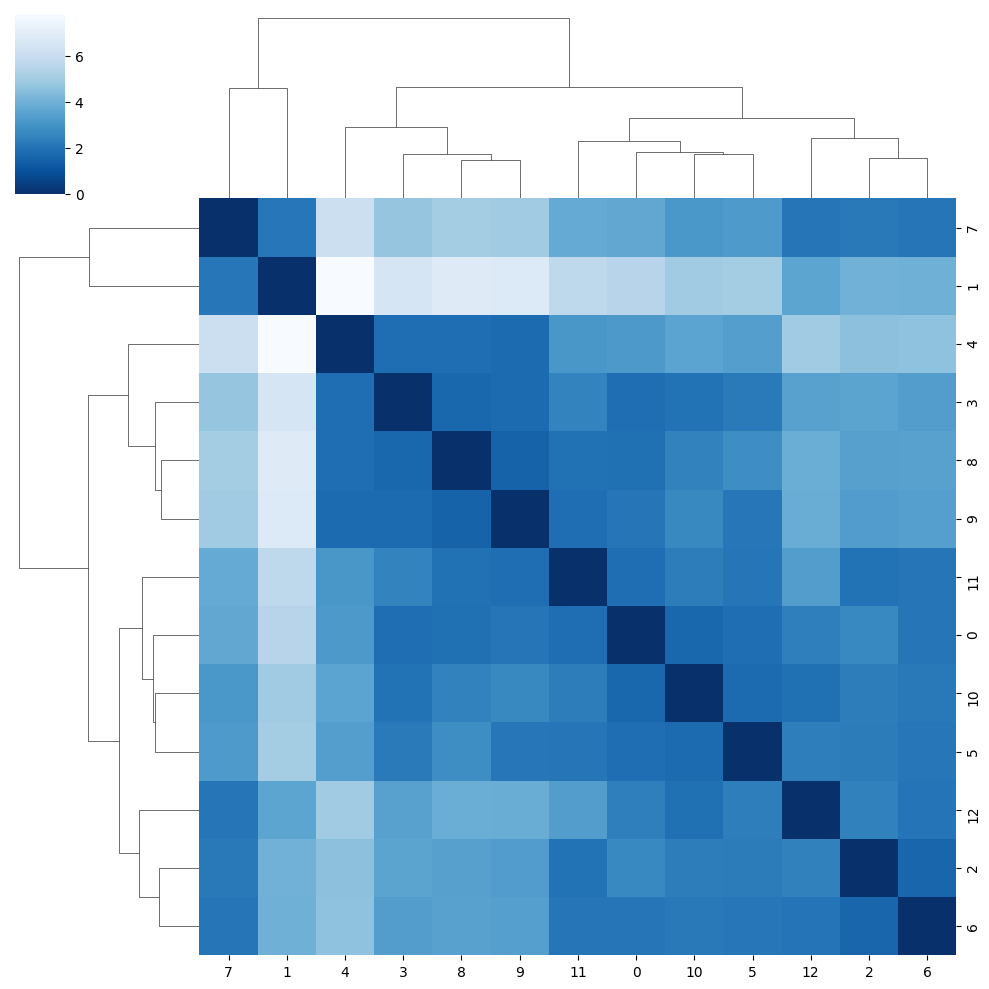

In [112]:
plot= sns.clustermap(pt_out[1], cmap="Blues_r")
